In [88]:
import pandas as pd
import numpy as np
np.float_ = np.float64
from prophet import Prophet
from sklearn.model_selection import train_test_split
from cstm_pkg_grp_9.data.sets import pop_target
from joblib import dump
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

# Load Data

In [47]:
train_df = pd.read_csv("../../data/processed/train_forecasting.csv")
X_test = pd.read_csv("../../data/processed/test_forecasting.csv")
holiday_df = pd.read_csv("../../data/processed/holiday_data.csv")

In [48]:
train_df.head()

,ds,y
0,2011-01-29,81650.61
1,2011-01-30,78970.57
2,2011-01-31,57706.91
3,2011-02-01,60761.20
4,2011-02-02,46959.95


In [49]:
X_test.head()

,ds,y
0,2015-04-19,141758.65
1,2015-04-20,105781.23
2,2015-04-21,96606.05
3,2015-04-22,95237.65
4,2015-04-23,96460.08


In [50]:
holiday_df.head()

,ds,holiday,event_type
0,2011-02-06,SuperBowl,Sporting
1,2011-02-14,ValentinesDay,Cultural
2,2011-02-21,PresidentsDay,National
3,2011-03-09,LentStart,Religious
4,2011-03-16,LentWeek2,Religious


# Splitting data

In [51]:
def split_sets_by_time(df, target_col, val_ratio=0.3):
    """Split sets by indexes for an ordered dataframe

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe
    target_col : str
        Name of the target column
    test_ratio : float
        Ratio used for the validation set (default: 0.3)

    Returns
    -------
    Numpy Array
        Features for the training set
    Numpy Array
        Target for the training set
    Numpy Array
        Features for the validation set
    Numpy Array
        Target for the validation set
    """

    df_copy = df.copy()
    
    # Calculate the cutoff index for the validation set
    cutoff = int(len(df_copy) * (1 - val_ratio))

    # Split into training and validation sets
    X_train = df_copy.iloc[:cutoff]
    X_val = df_copy.iloc[cutoff:]

    X_train['ds'] = pd.to_datetime(X_train['ds'])
    X_val['ds'] = pd.to_datetime(X_val['ds'])

    return X_train, X_val

In [52]:
X_train, X_val = split_sets_by_time(train_df, 'y')

/var/folders/y7/4mw_ll2n3zz0kzg7v6kt7kwm0000gn/T/ipykernel_63077/3819405913.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ds'] = pd.to_datetime(X_train['ds'])
/var/folders/y7/4mw_ll2n3zz0kzg7v6kt7kwm0000gn/T/ipykernel_63077/3819405913.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['ds'] = pd.to_datetime(X_val['ds'])


In [53]:
X_train.shape

(1078, 2)

In [54]:
X_train.head()

,ds,y
0,2011-01-29,81650.61
1,2011-01-30,78970.57
2,2011-01-31,57706.91
3,2011-02-01,60761.20
4,2011-02-02,46959.95


In [55]:
X_val.head()

,ds,y
1078,2014-01-11,130728.23
1079,2014-01-12,127825.47
1080,2014-01-13,91681.04
1081,2014-01-14,81989.30
1082,2014-01-15,87791.59


# Modelling

## Baseline Model

In [56]:
import pandas as pd
import numpy as np

class NullRegressor:
    """
    Class used as baseline model for regression problem
    ...

    Attributes
    ----------
    y : Numpy Array-like
        Target variable
    pred_value : Float
        Value to be used for prediction
    preds : Numpy Array
        Predicted array

    Methods
    -------
    fit(y)
        Store the input target variable and calculate the predicted value to be used
    predict(y)
        Generate the predictions
    fit_predict(y)
        Perform a fit followed by predict
    """


    def __init__(self):
        self.y = None
        self.pred_value = None
        self.preds = None

    def fit(self, y):
        self.y = y
        self.pred_value = y.mean()

    def predict(self, y):
        self.preds = np.full((len(y), 1), self.pred_value)
        return self.preds

    def fit_predict(self, y):
        self.fit(y)
        return self.predict(self.y)

In [57]:
def print_regressor_scores(y_preds, y_actuals, set_name=None):
    """Print the RMSE and MAE for the provided data

    Parameters
    ----------
    y_preds : Numpy Array
        Predicted target
    y_actuals : Numpy Array
        Actual target
    set_name : str
        Name of the set to be printed

    Returns
    -------
    """
    from sklearn.metrics import root_mean_squared_error as rmse
    from sklearn.metrics import mean_absolute_error as mae

    print(f"RMSE {set_name}: {rmse(y_actuals, y_preds)}")
    print(f"MAE {set_name}: {mae(y_actuals, y_preds)}")

In [58]:
base_model = NullRegressor()

In [59]:
y_base = base_model.fit_predict(X_train['y'])
print_regressor_scores(y_preds=y_base, y_actuals=X_train['y'], set_name='Training')

RMSE Training: 19157.990283984393
MAE Training: 15062.90094094747


In [60]:
y_base = base_model.fit_predict(X_val['y'])
print_regressor_scores(y_preds=y_base, y_actuals=X_val['y'], set_name='Validation')

RMSE Validation: 18412.274516637794
MAE Validation: 14610.651879889352


In [61]:
y_base = base_model.fit_predict(X_test['y'])
print_regressor_scores(y_preds=y_base, y_actuals=X_test['y'], set_name='Testing')

RMSE Testing: 21528.022059992873
MAE Testing: 17126.342404125


## Model 1

In [62]:
prophet = Prophet()

In [63]:
prophet.fit(X_train)

13:04:20 - cmdstanpy - INFO - Chain [1] start processing
13:04:21 - cmdstanpy - INFO - Chain [1] done processing


In [70]:
forecast_train = prophet.predict(X_train)

In [72]:
print_regressor_scores(forecast_train['yhat'], X_train['y'], set_name='Training')

RMSE Training: 8658.159741909907
MAE Training: 6122.717796413293


In [19]:
forecast = prophet.predict(X_val)

/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


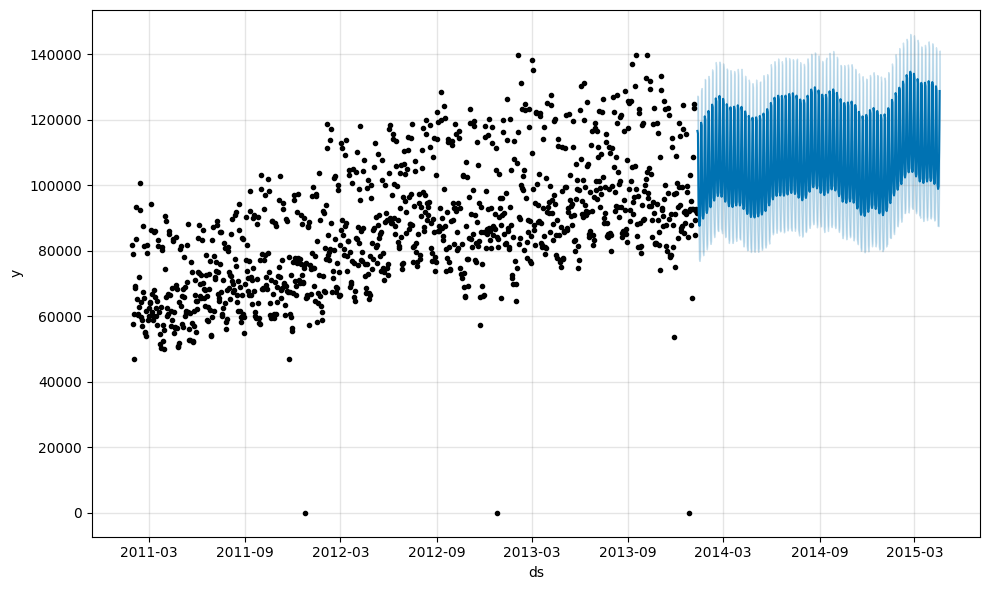

In [20]:
fig1 = prophet.plot(forecast)

/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/

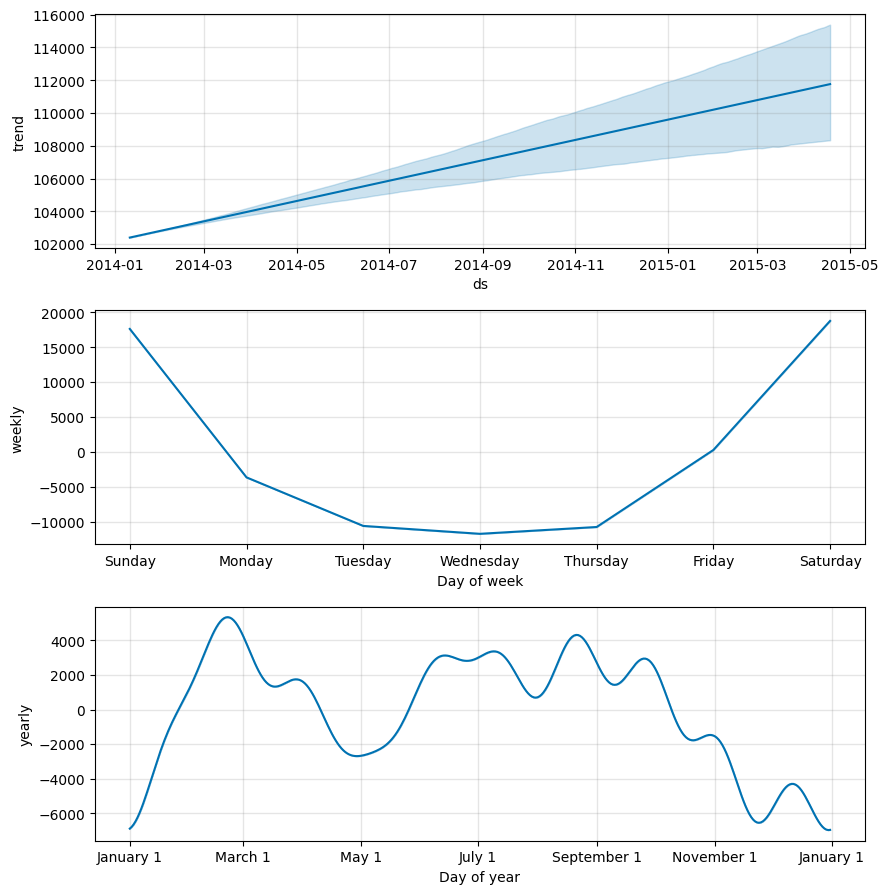

In [21]:
fig2 = prophet.plot_components(forecast)

In [22]:
print_regressor_scores(forecast['yhat'], X_val['y'], set_name='Validation')

RMSE Validation: 10330.048186257845
MAE Validation: 7753.4398739646795


## Model 2 - With Holiday Dates

In [66]:
prophet1 = Prophet(holidays=holiday_df)

In [67]:
prophet1.fit(X_train)

13:06:09 - cmdstanpy - INFO - Chain [1] start processing
13:06:09 - cmdstanpy - INFO - Chain [1] done processing


In [76]:
forecast_train = prophet1.predict(X_train)

In [77]:
print_regressor_scores(forecast_train['yhat'], X_train['y'], set_name='Training')

RMSE Training: 6795.6241949813575
MAE Training: 5402.595706495359


In [25]:
forecast = prophet1.predict(X_val)

/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


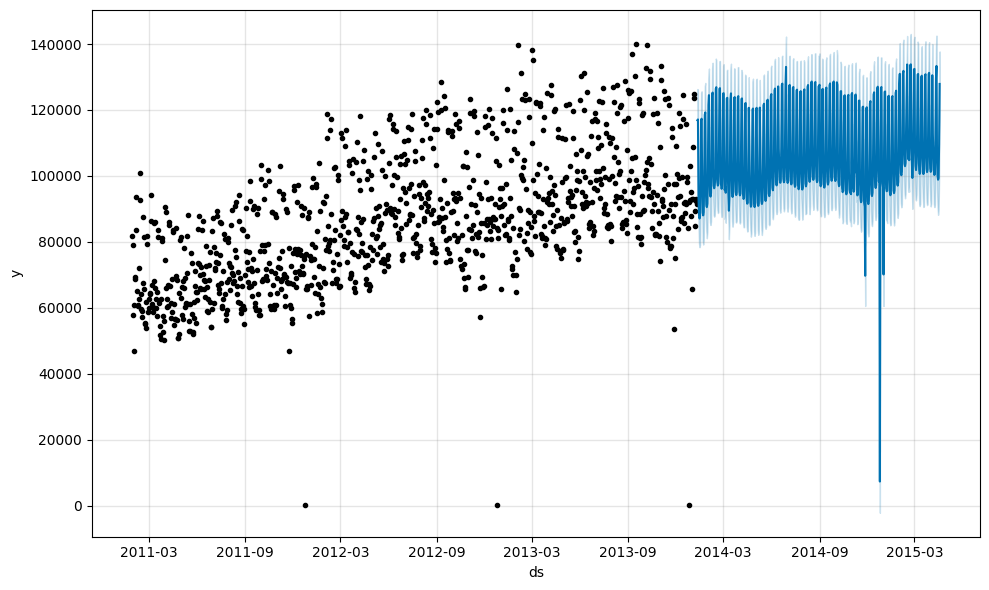

In [26]:
fig1 = prophet1.plot(forecast)

/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/

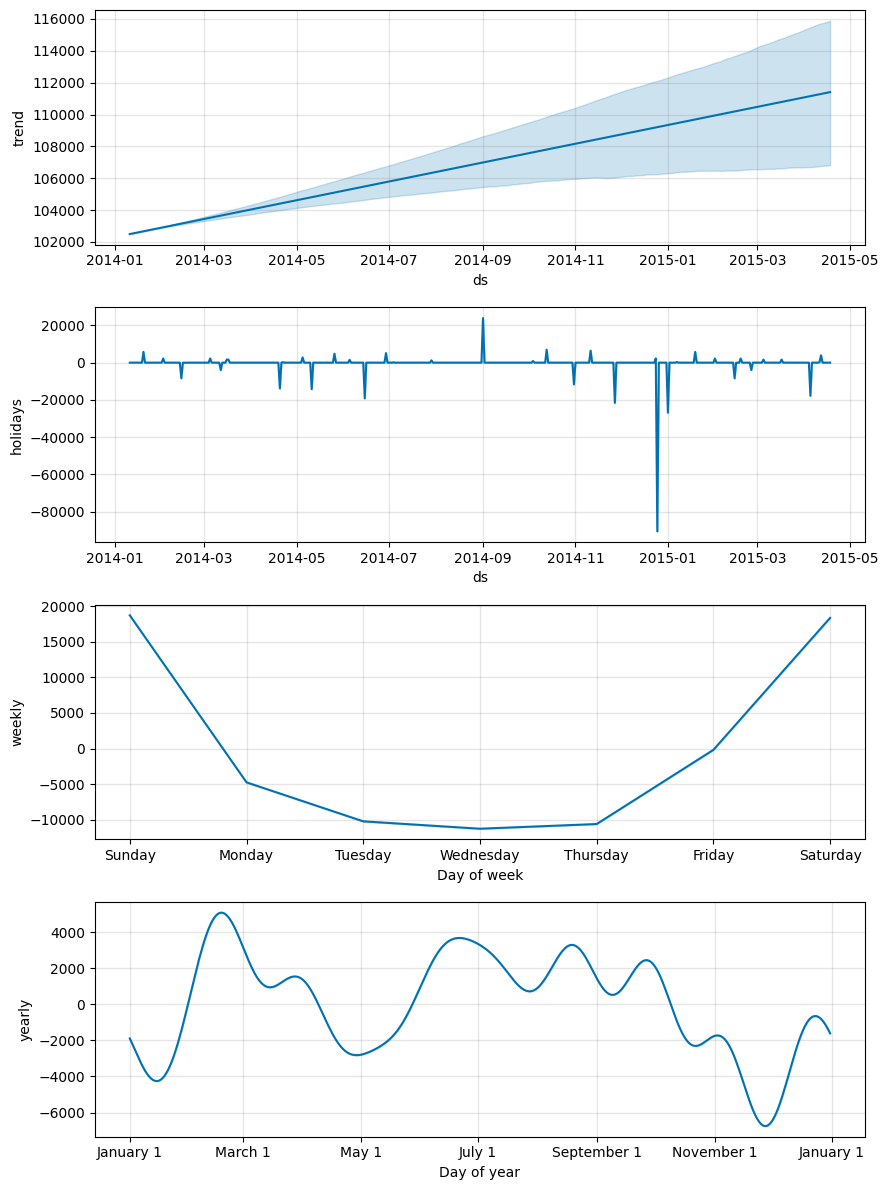

In [27]:
fig2 = prophet1.plot_components(forecast)

In [29]:
print_regressor_scores(forecast['yhat'], X_val['y'], set_name='Validation')

RMSE Validation: 9096.95281121517
MAE Validation: 7362.333896697344


## Model 3 - Cross Validation

In [78]:
prophet3 = Prophet(holidays=holiday_df)

In [79]:
prophet3.fit(X_train)

13:09:46 - cmdstanpy - INFO - Chain [1] start processing
13:09:46 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
cv_results1 = cross_validation(prophet3, initial='365 days', period='7 days', horizon='7 days')

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|                                                   | 0/101 [00:00<?, ?it/s]13:09:49 - cmdstanpy - INFO - Chain [1] start processing
13:09:49 - cmdstanpy - INFO - Chain [1] done processing
13:09:49 - cmdstanpy - INFO - Chain [1] start processing
13:09:49 - cmdstanpy - INFO - Chain [1] done processing
  2%|▊                                          | 2/101 [00:00<00:08, 12.16it/s]13:09:49 - cmdstanpy - INFO - Chain [1] start processing
13:09:49 - cmdstanpy - INFO - Chain [1] done processing
13:09:49 - cmdstanpy - INFO - Chain [1] start processing
13:09:49 - cmdstanpy - INFO - Chain [1] done processing
  4%|█▋                                         | 4/101 [00:00<00:07, 12.57it/s]13:09:49 - cmdstanpy - INFO - Chain [1] start processing
13:09:49 - cmdstanpy - INFO - Chain [1] done processing
13:09:49 - cmdstanpy - INFO - Chain [1] start processing
13:09:49 - cmdstanpy - INFO - Chai

In [81]:
forecast_train = prophet3.predict(X_train)

In [82]:
print_regressor_scores(forecast_train['yhat'], X_train['y'], set_name='Training')

RMSE Training: 6795.6241949813575
MAE Training: 5402.595706495359


In [34]:
forecast = prophet3.predict(X_val)

/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


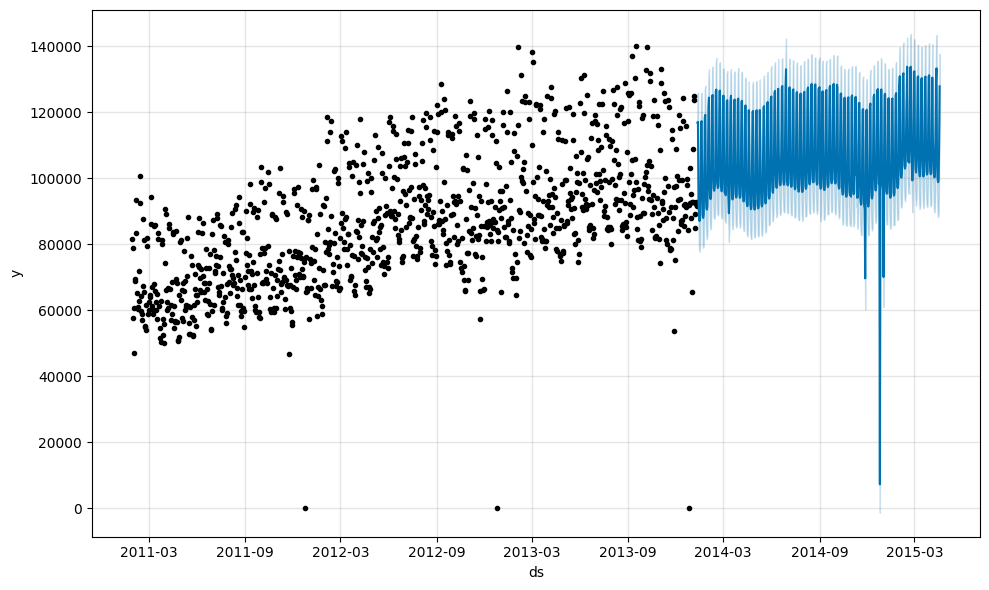

In [35]:
fig1 = prophet3.plot(forecast)

/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


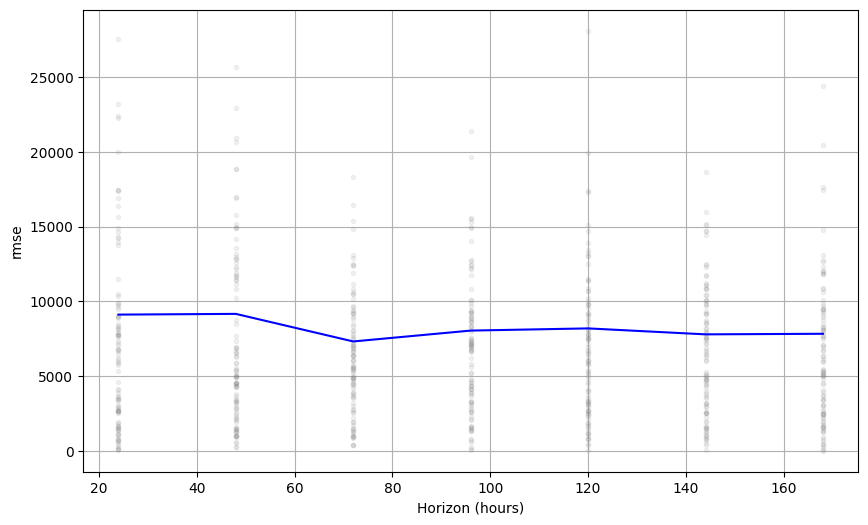

In [36]:
fig2 = plot_cross_validation_metric(cv_results1, metric='rmse')

/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/

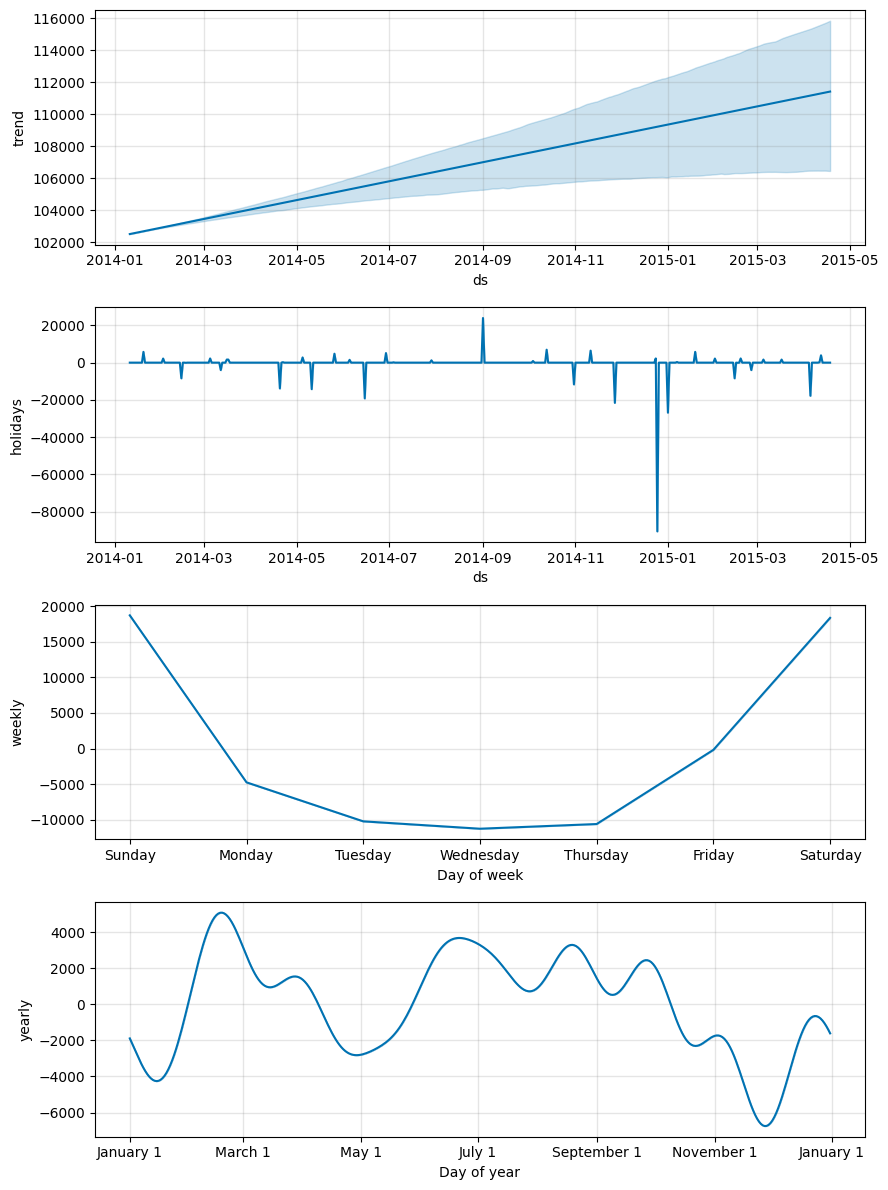

In [37]:
fig3 = prophet3.plot_components(forecast)

In [38]:
print_regressor_scores(forecast['yhat'], X_val['y'], set_name='Validation')

RMSE Validation: 9096.95281121517
MAE Validation: 7362.333896697344


# Best model test set results

In [40]:
forecast = prophet1.predict(X_test)

/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/sidhantbajaj/Library/Caches/pypoetry/virtualenvs/model-experimentation-5XOMBbnH-py3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


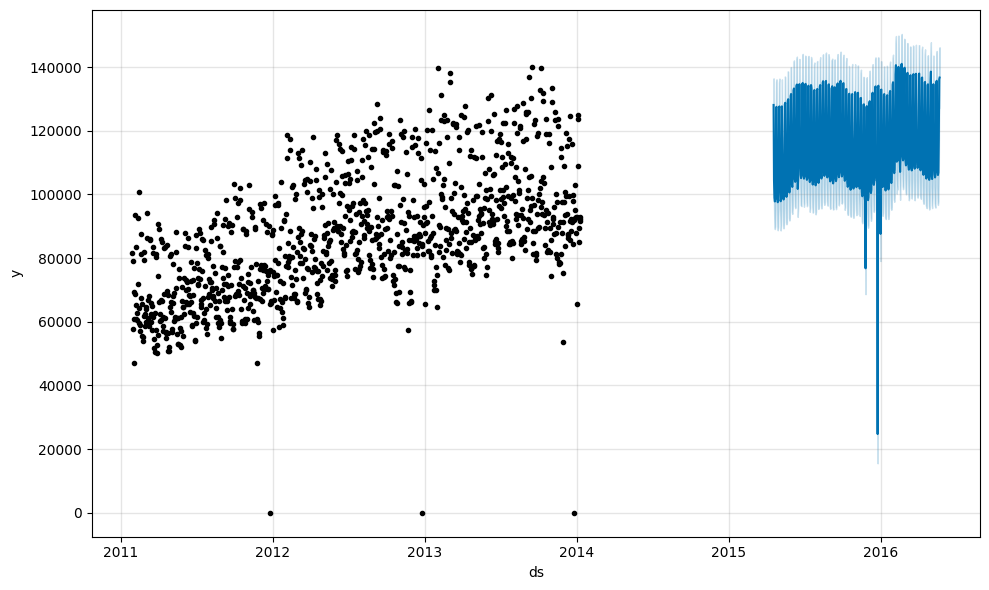

In [41]:
fig1 = prophet1.plot(forecast)

In [43]:
print_regressor_scores(forecast['yhat'], X_test['y'], set_name='Test')

RMSE Test: 14415.567796961433
MAE Test: 11083.19717897722


In [44]:
dump(prophet1,  '../../models/forecasting/prophet1.joblib')

['../../models/forecasting/prophet1.joblib']